# Decoding position from firing rates 

In this example we show how position can be decoded from neural firing rates. For this you will use (very simply) sklearn's linear regression model. 

The plan is as follows. 
1. Initialise a 2D `Environment` an `Agent` and some populations of various types of `Neurons` 
1. Explore the environment for 10 minutes, then train decoders to map firing rates to positions from the "training" data generates.
1. Explore for 1 extra minute. Decode position from this "testing" data. Compare to the true position.


In [1]:
from ratinabox import *
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells,GridCells,BoundaryVectorCells

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor

First make a function `train_decoder()` which takes in a population of `Neurons` and trains two decoders (Gaussian process and linear ridge regression) on data stored in its history data frame. These decoders are saved into the class as attributes. 

A second function `decode_position()` takes a population of `Neurons` and decodes position from firing rate data in is history data frame and the decoders just trained. 

In [2]:
def train_decoder(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on."""
    #Get training data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end][::5] #subsample data for training (most of it is redundant anyway)
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end][::5]
    pos = np.array(Neurons.Agent.history['pos'])[i_start:i_end][::5]
    #Initialise and fit model
    model_GP = GaussianProcessRegressor(alpha=0.01)
    model_LR = Ridge(alpha=0.01)
    model_GP.fit(fr,pos)    
    model_LR.fit(fr,pos)    
    #Save models into Neurons class for later use
    Neurons.decoding_model_GP = model_GP
    Neurons.decoding_model_LR = model_LR
    return 

def decode_position(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on.
    Returns a list of times and decoded positions"""
    #Get testing data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end]
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end]
    #decode position from the data and using the decoder saved in the  Neurons class 
    decoded_position_GP = Neurons.decoding_model_GP.predict(fr)
    decoded_position_LR = Neurons.decoding_model_LR.predict(fr)
    return (t, decoded_position_GP, decoded_position_LR)

Initialise Environment, Agent, and cell populations. We will compare place cells, grid cells and boundary vectory cells. 

In [5]:
Env = Environment()
Ag = Agent(Env)
Ag.dt = 50e-3


PCs = PlaceCells(Ag,params={'n':20,'color':'C1'})
GCs = GridCells(Ag,params={'n':20,'color':'C2','gridscale':0.4},)
BVCs = BoundaryVectorCells(Ag,params={'n':20,'color':'C3'})

Generate training data (5 minutes of random exploration)...

(<Figure size 432x288 with 40 Axes>, None)

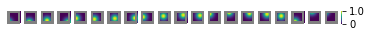

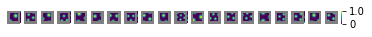

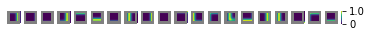

In [6]:
PCs.plot_rate_map(chosen_neurons='all')
GCs.plot_rate_map(chosen_neurons='all')
BVCs.plot_rate_map(chosen_neurons='all')

100%|██████████| 6000/6000 [00:08<00:00, 707.18it/s]


(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

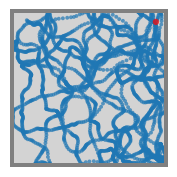

In [7]:
from tqdm import tqdm 
for i in tqdm(range(int(5*60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()
Ag.plot_trajectory()

...and train decoder models.

In [8]:
train_decoder(PCs)
train_decoder(GCs)
train_decoder(BVCs)

Now generate an additional minute of testing data and "decode" position from it.

In [9]:
for i in tqdm(range(int(60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

t, pos_PCs_GP, pos_PCs_LR = decode_position(PCs,t_start=Ag.t-60)
t, pos_GCs_GP, pos_GCs_LR = decode_position(GCs,t_start=Ag.t-60)
t, pos_BVCs_GP, pos_BVCs_LR = decode_position(BVCs,t_start=Ag.t-60)

100%|██████████| 1200/1200 [00:01<00:00, 708.98it/s]


Visualise results: blue is the ground truth (real position) whereas coloured traces are the decodings. Compare the Gaussian process regression to linear regression

Text(0.5, 1.0, 'Boundary vector cells')

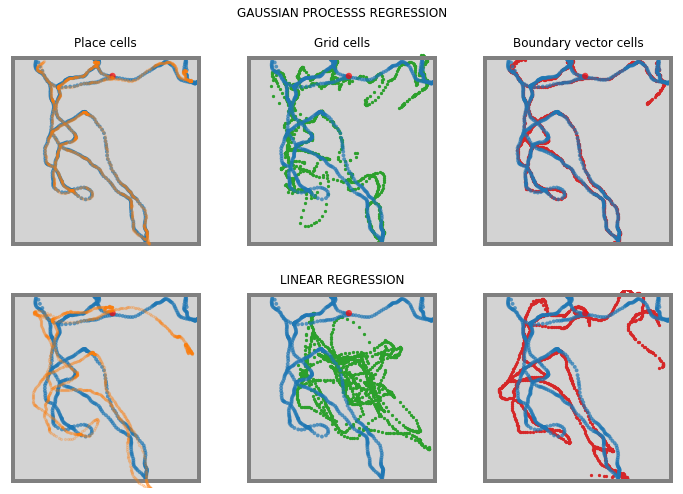

In [10]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,0])
ax[0,0].scatter(pos_PCs_GP[:,0],pos_PCs_GP[:,1],s=5,c='C1',alpha=0.2,zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,0])
ax[1,0].scatter(pos_PCs_LR[:,0],pos_PCs_LR[:,1],s=5,c='C1',alpha=0.2,zorder=3.1)
ax[0,0].set_title("Place cells")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,1])
ax[0,1].scatter(pos_GCs_GP[:,0],pos_GCs_GP[:,1],s=5,c='C2',alpha=1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,1])
ax[1,1].scatter(pos_GCs_LR[:,0],pos_GCs_LR[:,1],s=5,c='C2',alpha=1)
ax[0,1].set_title("GAUSSIAN PROCESSS REGRESSION\n\nGrid cells")
ax[1,1].set_title("LINEAR REGRESSION")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,2])
ax[0,2].scatter(pos_BVCs_GP[:,0],pos_BVCs_GP[:,1],s=5,c='C3',alpha=1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,2])
ax[1,2].scatter(pos_BVCs_LR[:,0],pos_BVCs_LR[:,1],s=5,c='C3',alpha=1)
ax[0,2].set_title("Boundary vector cells")